## Group6 Project

### Topic: Movie recommendation

Presented by Minseok Oh, Ajinkya Desai

## Table of contents

1. Project & Dataset Description
2. Data exploration and preprocessing
3. Modeling (Collaborative filtering & Content-based filtering)
4. Predictions & Findings
5. Conclusion

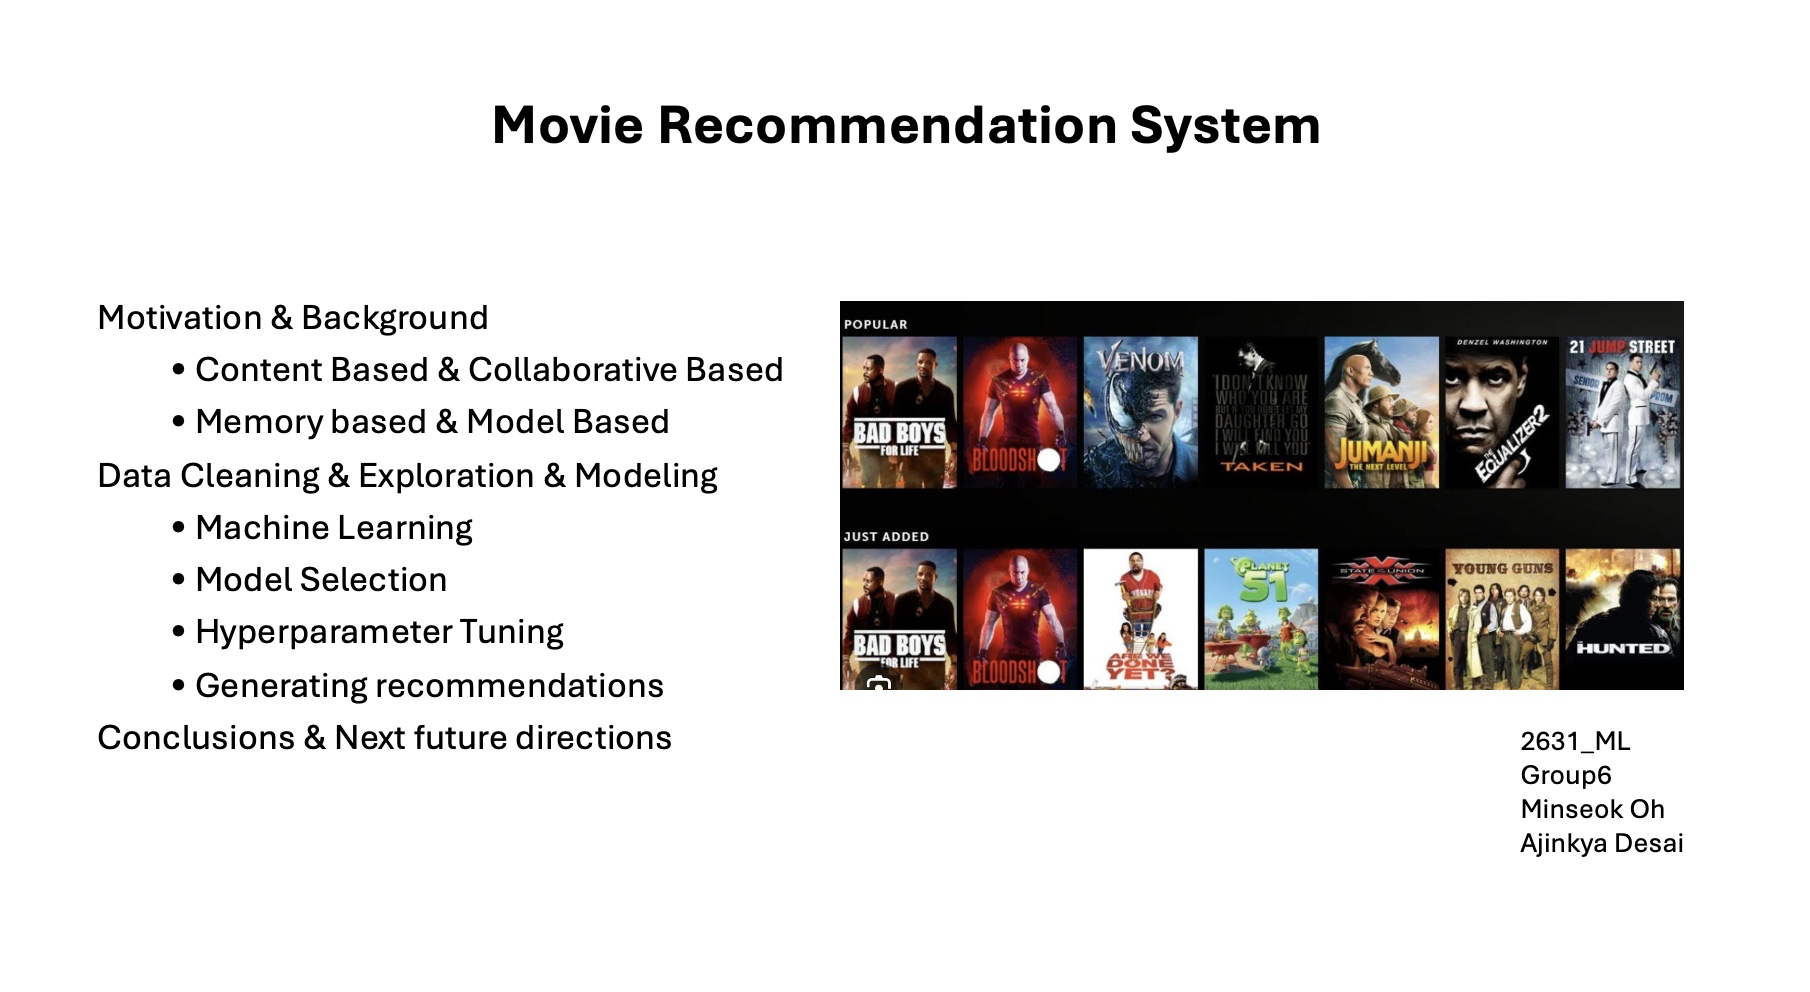

In [11]:
from IPython.display import Image, display
display(Image(filename='main.png', width=600, height=600))

### 1-1. Project Description

Our project focuses on movie recommendation systems, comparing collaborative and content-based filtering techniques using movie metadata and user ratings datasets. We will highlight each method's pros and cons and discuss our project's limitations and future directions.

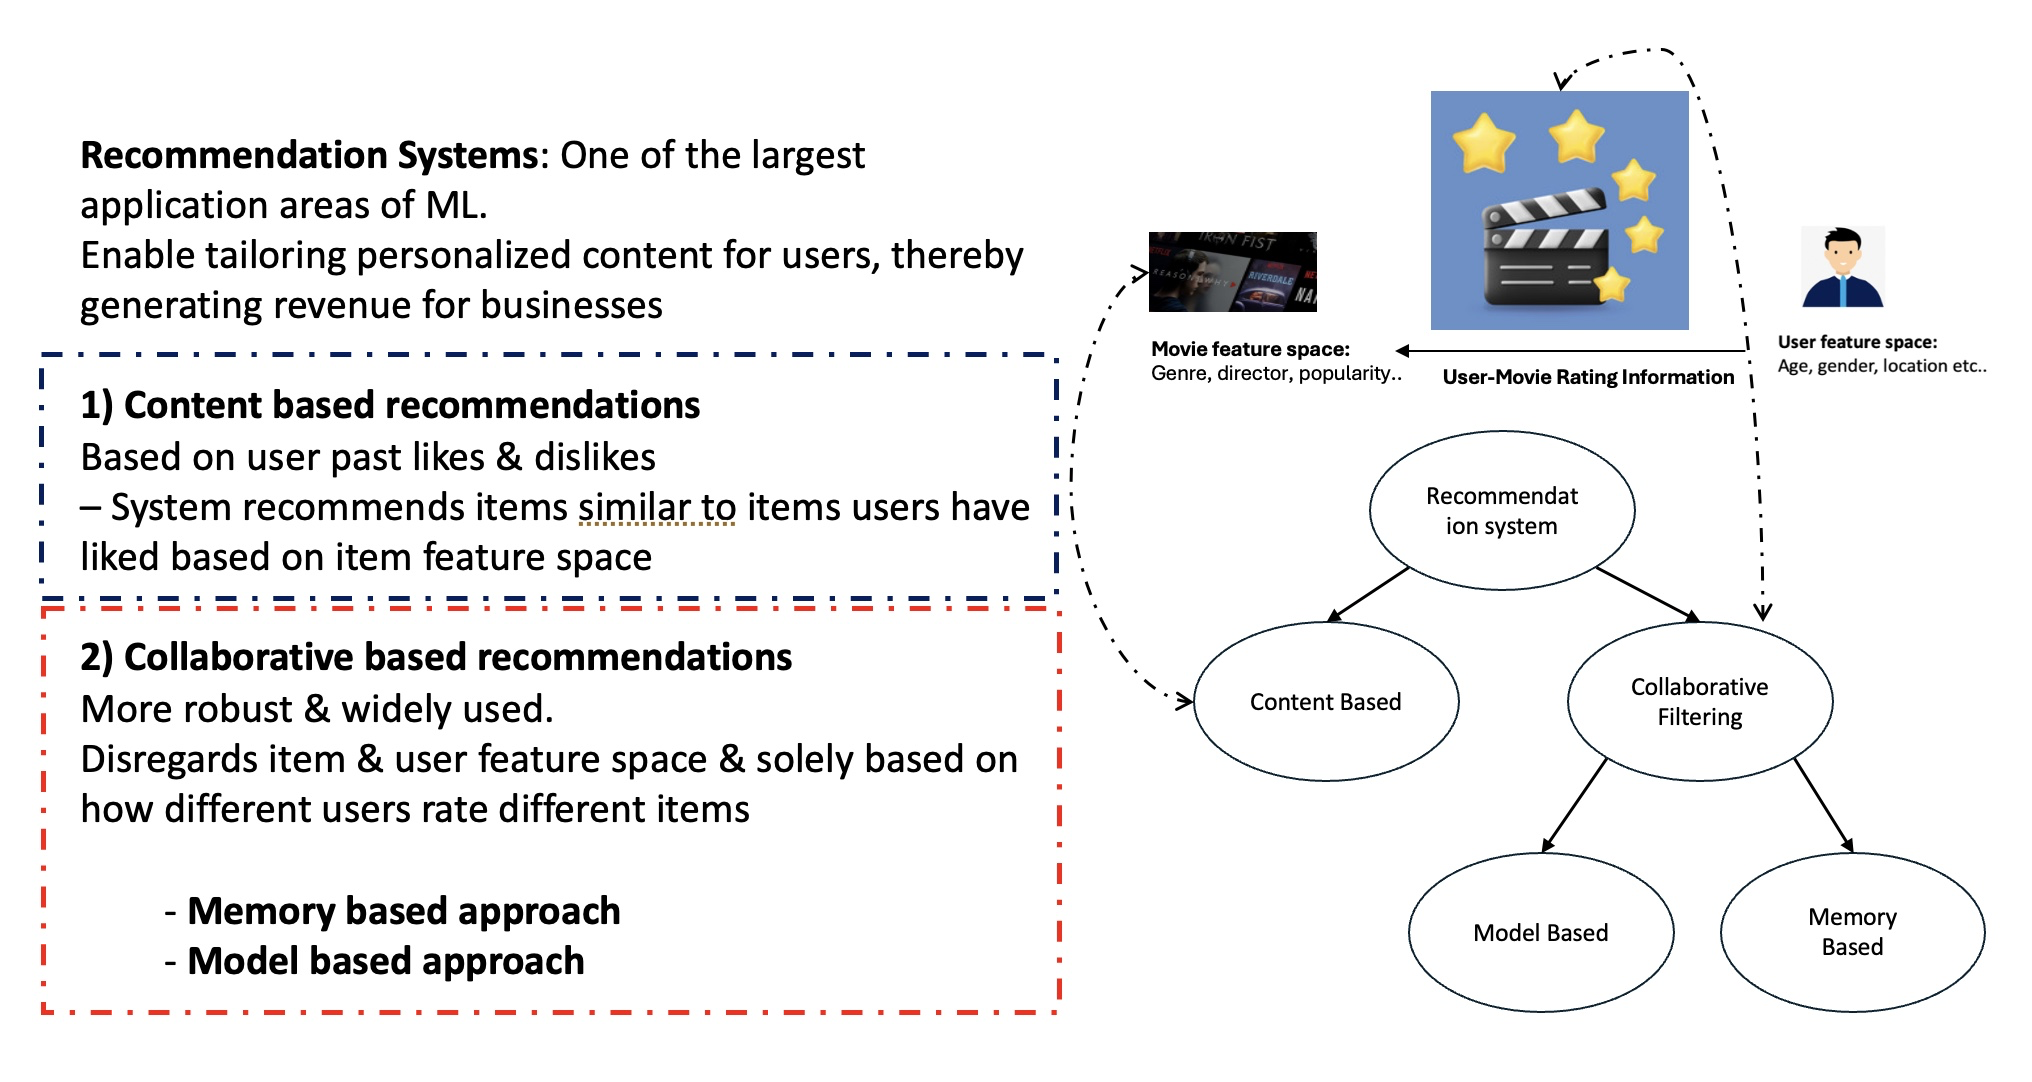

In [2]:
from IPython.display import Image, display
display(Image(filename='description.png', width=600, height=600))

### 1-2. Dataset Description
**movies_metadata.csv**

1. **adult**: Indicates if the movie is for adults only (boolean flag).
2. **belongs_to_collection**: Specifies if the movie is part of a collection or series.
3. **budget**: The budget allocated for the production of the movie.
4. **genres**: Lists the genres associated with the movie.
5. **homepage**: The official website or webpage for the movie.
6. **id**: A unique identifier for the movie within the dataset.
7. **imdb_id**: The movie's unique identifier in the IMDb database.
8. **original_language**: The language in which the movie was originally produced.
9. **original_title**: The title of the movie in its original language.
10. **overview**: A brief summary or description of the movie's plot.
11. **popularity**: A metric indicating the movie's popularity.
12. **poster_path**: The file path or URL to the movie's poster image.
13. **production_companies**: The companies involved in producing the movie.
14. **production_countries**: The countries where the movie was produced.
15. **release_date**: The official release date of the movie.
16. **revenue**: The total box office revenue generated by the movie.
17. **runtime**: The total duration of the movie in minutes.
18. **spoken_languages**: The languages spoken in the movie.
19. **status**: The current status of the movie (e.g., Released, Post-Production).
20. **tagline**: A memorable phrase or slogan associated with the movie.
21. **title**: The official title of the movie.
22. **video**: Indicates whether a video clip or trailer is available (boolean flag).
23. **vote_average**: The average rating given to the movie by viewers.
24. **vote_count**: The total number of votes or ratings the movie has received. 


**movies.csv**

1. **movieId**: A unique identifier for the movie within the dataset.
2. **title**: The official title of the movie.
3. **genres**: A list of genres that the movie is associated with, often separated by a delimiter.</br>

**ratings.csv**
1. **userId:** Unique user identifier.
2. **movieId:** Unique movie identifier.
3. **rating:** User's rating for the movie.
4. **timestamp:** Time of rating submission.



### 2. Data exploration & preprocessing

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
df_ratings = pd.read_csv('ratings.csv')

In [4]:
df_ratings.head()

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

In [6]:
user_counts = df_ratings['userId'].value_counts()

In [7]:
# Understand the number of values per userId
count_user_1 = user_counts.get(1, 0)

In [8]:
count_user_2 = user_counts.get(2, 0)

In [11]:
count_user_1

70

In [12]:
count_user_2

184

In [ ]:
# Total dataset size
df_ratings.shape

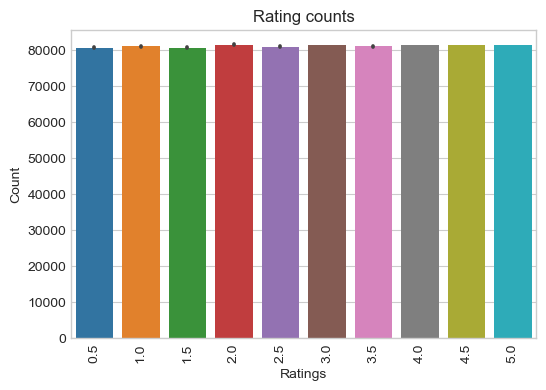

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_ratings, x='rating', y='userId')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Rating counts')
plt.xticks(rotation=90)
plt.show();

Creating plot to see the distribution of ratings. Plotting the ratings distribution reveals an even spread.

#### Data exploration & preprocessing: movies and metadata

In [9]:
movies = pd.read_csv('movies.csv')
metadata = pd.read_csv('movies_metadata.csv')

# Removing special charaters
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies

movieId                        title  \
0            1                    Toy Story   
1            2                      Jumanji   
2            3             Grumpier Old Men   
3            4            Waiting to Exhale   
4            5  Father of the Bride Part II   
...        ...                          ...   
62418   209157                           We   
62419   209159           Window of the Soul   
62420   209163                    Bad Poems   
62421   209169                 A Girl Thing   
62422   209171      Women of Devil's Island   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
62418                                        Drama  
62419                                  Documentary  
62420                                 Comedy|Drama  
62421                           (no genres listed)  
62422                       Action|Adventure|Drama  

[62423 rows x 3 columns]

In [10]:
# Merging the two dataframes on the 'title' column
merged_movie_meta_df = pd.merge(movies, metadata, on='title', how='left')

In [11]:
merged_movie_meta_df.columns   

Index(['movieId', 'title', 'genres_x', 'adult', 'belongs_to_collection',
       'budget', 'genres_y', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [12]:
merged_movie_meta_df.head(2)

movieId      title                                     genres_x  adult  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy  False   
1        2    Jumanji                   Adventure|Children|Fantasy  False   

                               belongs_to_collection    budget  \
0  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1                                                NaN  65000000   

                                            genres_y  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   

                               homepage    id    imdb_id  ...  \
0  http://toystory.disney.com/toy-story   862  tt0114709  ...   
1                                   NaN  8844  tt0113497  ...   

                                production_countries release_date  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-10-30   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-15   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   

     status                                    tagline  video  vote_average  \
0  Released                                        NaN  False           7.7   
1  Released  Roll the dice and unleash the excitement!  False           6.9   

   vote_count  
0      5415.0  
1      2413.0  

[2 rows x 26 columns]

In [13]:
# List of columns to keep 
columns_to_keep = [
    'movieId','title', 'genres_y', 'budget', 'popularity',
    'production_companies', 'production_countries', 'release_date', 'revenue',
    'runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count'
]

merged_movie_meta_df = merged_movie_meta_df[columns_to_keep]

In [14]:
import pandas as pd
import ast

# Function to extract names from a list of dictionaries
def extract_names(column_data):
    try:
        data = ast.literal_eval(column_data)
        if isinstance(data, list):
            return ', '.join([d['name'] for d in data if 'name' in d])
        elif isinstance(data, dict):
            return data.get('name', None)
    except (ValueError, SyntaxError, TypeError):
        return None  

merged_movie_meta_df['production_companies'] = merged_movie_meta_df['production_companies'].apply(extract_names)
merged_movie_meta_df['production_countries'] = merged_movie_meta_df['production_countries'].apply(extract_names)
merged_movie_meta_df['spoken_languages'] = merged_movie_meta_df['spoken_languages'].apply(extract_names)
merged_movie_meta_df['genres_y'] = merged_movie_meta_df['genres_y'].apply(extract_names)

merged_movie_meta_df.head(2)

movieId      title                    genres_y    budget popularity  \
0        1  Toy Story   Animation, Comedy, Family  30000000  21.946943   
1        2    Jumanji  Adventure, Fantasy, Family  65000000  17.015539   

                                production_companies  \
0                            Pixar Animation Studios   
1  TriStar Pictures, Teitler Film, Interscope Com...   

       production_countries release_date      revenue  runtime  \
0  United States of America   1995-10-30  373554033.0     81.0   
1  United States of America   1995-12-15  262797249.0    104.0   

    spoken_languages    status  vote_average  vote_count  
0            English  Released           7.7      5415.0  
1  English, Français  Released           6.9      2413.0

In [15]:
# Convert 'budget' and 'popularity' to float
merged_movie_meta_df['budget'] = pd.to_numeric(merged_movie_meta_df['budget'], errors='coerce')
merged_movie_meta_df['popularity'] = pd.to_numeric(merged_movie_meta_df['popularity'], errors='coerce')

# Convert 'release_date' to datetime
merged_movie_meta_df['release_date'] = pd.to_datetime(merged_movie_meta_df['release_date'], errors='coerce', format='%Y-%m-%d')

# The columns 'title', 'original_title', 'overview', 'production_companies', 'production_countries', 'spoken_languages', 'status', and 'tagline' are textual and can remain as object (string) type
merged_movie_meta_df.dtypes

movieId                          int64
title                           object
genres_y                        object
budget                         float64
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                        float64
runtime                        float64
spoken_languages                object
status                          object
vote_average                   float64
vote_count                     float64
dtype: object

In [16]:
merged_movie_meta_df.isna().sum()

movieId                     0
title                       0
genres_y                28485
budget                  28485
popularity              28485
production_companies    28485
production_countries    28485
release_date            28545
revenue                 28485
runtime                 28691
spoken_languages        28485
status                  28558
vote_average            28485
vote_count              28485
dtype: int64

In [17]:
# Drop rows where any of the specified columns have null values
merged_movie_meta_df.dropna(subset=['production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status'], inplace=True)

merged_movie_meta_df.isnull().sum()

movieId                   0
title                     0
genres_y                  0
budget                    0
popularity                0
production_companies      0
production_countries      0
release_date              0
revenue                   0
runtime                 196
spoken_languages          0
status                    0
vote_average              0
vote_count                0
dtype: int64

In [18]:
# Keep the first value from the 'production_companies', 'production_countries', 'spoken_languages' column
merged_movie_meta_df['production_companies'] = merged_movie_meta_df['production_companies'].apply(lambda x: x.split(",")[0] if pd.notnull(x) else x)

merged_movie_meta_df['production_countries'] = merged_movie_meta_df['production_countries'].apply(lambda x: "United States of America" if "United States of America" in x else x)

merged_movie_meta_df['spoken_languages'] = merged_movie_meta_df['spoken_languages'].apply(lambda x: "English" if "English" in x else x)


In [19]:
# Calculate the threshold for dropping columns
threshold = len(merged_movie_meta_df) * 0.7

columns_to_drop = merged_movie_meta_df.columns[merged_movie_meta_df.isnull().sum() > threshold]

print(columns_to_drop)


Index([], dtype='object')


In [20]:
# Inserting values: compare median vs mean and insert accordingly
for column in merged_movie_meta_df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = merged_movie_meta_df[column].median()
    mean_val = merged_movie_meta_df[column].mean()
    merged_movie_meta_df[column].fillna(median_val, inplace=True)


In [22]:
zero_counts = (merged_movie_meta_df == 0.0).sum()
zero_counts

movieId                     0
title                       0
genres_y                    0
budget                  32960
popularity                 29
production_companies        0
production_countries        0
release_date                0
revenue                 34290
runtime                  1326
spoken_languages            0
status                      0
vote_average             2719
vote_count               2622
dtype: int64

In [23]:
# Calculate the median value of the column ignoring zeros
median_value_budget = merged_movie_meta_df['budget'][merged_movie_meta_df['budget'] != 0].median()
median_value_popularity = merged_movie_meta_df['popularity'][merged_movie_meta_df['popularity'] != 0].median()
median_value_revenue = merged_movie_meta_df['revenue'][merged_movie_meta_df['revenue'] != 0].median()
median_value_runtime = merged_movie_meta_df['runtime'][merged_movie_meta_df['runtime'] != 0].median()

# Replace 0 values with the median value
merged_movie_meta_df['budget'].replace(0, median_value_budget, inplace=True)
merged_movie_meta_df['popularity'].replace(0, median_value_popularity, inplace=True)
merged_movie_meta_df['revenue'].replace(0, median_value_revenue, inplace=True)
merged_movie_meta_df['runtime'].replace(0, median_value_runtime, inplace=True)


In [24]:
merged_movie_meta_df.head(1)

movieId      title                   genres_y      budget  popularity  \
0        1  Toy Story  Animation, Comedy, Family  30000000.0   21.946943   

      production_companies      production_countries release_date  \
0  Pixar Animation Studios  United States of America   1995-10-30   

       revenue  runtime spoken_languages    status  vote_average  vote_count  
0  373554033.0     81.0          English  Released           7.7      5415.0

In [30]:
merged_movie_meta_df.isnull().sum().sum()

0

#### Data exploration & preprocessing : movies and ratings data

In [28]:
ratings = pd.read_csv('ratings.csv')
ratings

userId  movieId  rating   timestamp
0              1      296     5.0  1147880044
1              1      306     3.5  1147868817
2              1      307     5.0  1147868828
3              1      665     5.0  1147878820
4              1      899     3.5  1147868510
...          ...      ...     ...         ...
25000090  162541    50872     4.5  1240953372
25000091  162541    55768     2.5  1240951998
25000092  162541    56176     2.0  1240950697
25000093  162541    58559     4.0  1240953434
25000094  162541    63876     5.0  1240952515

[25000095 rows x 4 columns]

In [29]:
# Split the 'genres' column on the pipe character
# Keep only the first genre
movies['genres'] = movies['genres'].apply(lambda x: x.split('|')[0])
movies_exploded = movies.explode('genres')

print(movies_exploded.head())

   movieId                        title     genres
0        1                    Toy Story  Adventure
1        2                      Jumanji  Adventure
2        3             Grumpier Old Men     Comedy
3        4            Waiting to Exhale     Comedy
4        5  Father of the Bride Part II     Comedy


In [30]:
ratings.head(1) 

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044

In [31]:
# Merge the two dataframes (movies and ratings) on the 'title' column
merged_movie_ratings_df = pd.merge(movies_exploded, ratings, on='movieId', how='inner')
merged_movie_ratings_df

movieId                    title              genres  userId  \
0               1                Toy Story           Adventure       2   
1               1                Toy Story           Adventure       3   
2               1                Toy Story           Adventure       4   
3               1                Toy Story           Adventure       5   
4               1                Toy Story           Adventure       8   
...           ...                      ...                 ...     ...   
25000090   209157                       We               Drama  119571   
25000091   209159       Window of the Soul         Documentary  115835   
25000092   209163                Bad Poems              Comedy    6964   
25000093   209169             A Girl Thing  (no genres listed)  119571   
25000094   209171  Women of Devil's Island              Action  119571   

          rating   timestamp  
0            3.5  1141415820  
1            4.0  1439472215  
2            3.0  1573944252  
3            4.0   858625949  
4            4.0   890492517  
...          ...         ...  
25000090     1.5  1574280748  
25000091     3.0  1574280985  
25000092     4.5  1574284913  
25000093     3.0  1574291826  
25000094     3.0  1574291937  

[25000095 rows x 6 columns]

In [32]:
merged_movie_ratings_df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [33]:
# Group by 'genres' and count the number of ratings
genre_counts = merged_movie_ratings_df.groupby('genres')['userId'].count()
genre_counts

genres
(no genres listed)      26627
Action                7446918
Adventure             2485956
Animation              583278
Children               475401
Comedy                5790524
Crime                 1741510
Documentary            273597
Drama                 4733571
Fantasy                 89078
Film-Noir               33754
Horror                 672956
IMAX                       27
Musical                 32430
Mystery                250637
Romance                 33884
Sci-Fi                 101279
Thriller               179380
War                      4239
Western                 45049
Name: userId, dtype: int64

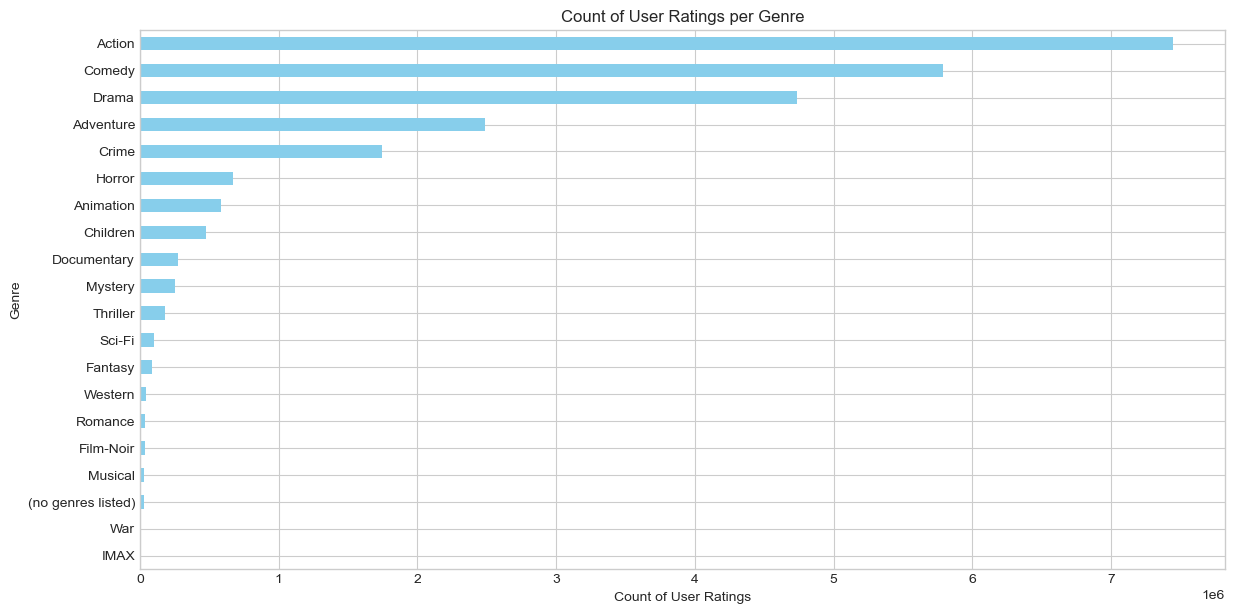

In [34]:
# Draw the plot user-ratings per movie genres 
plt.figure(figsize=(14, 7))
genre_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Count of User Ratings per Genre')
plt.xlabel('Count of User Ratings')
plt.ylabel('Genre')
plt.show()

Action, Comedy, Drama Adventure are the most popular movies genre.

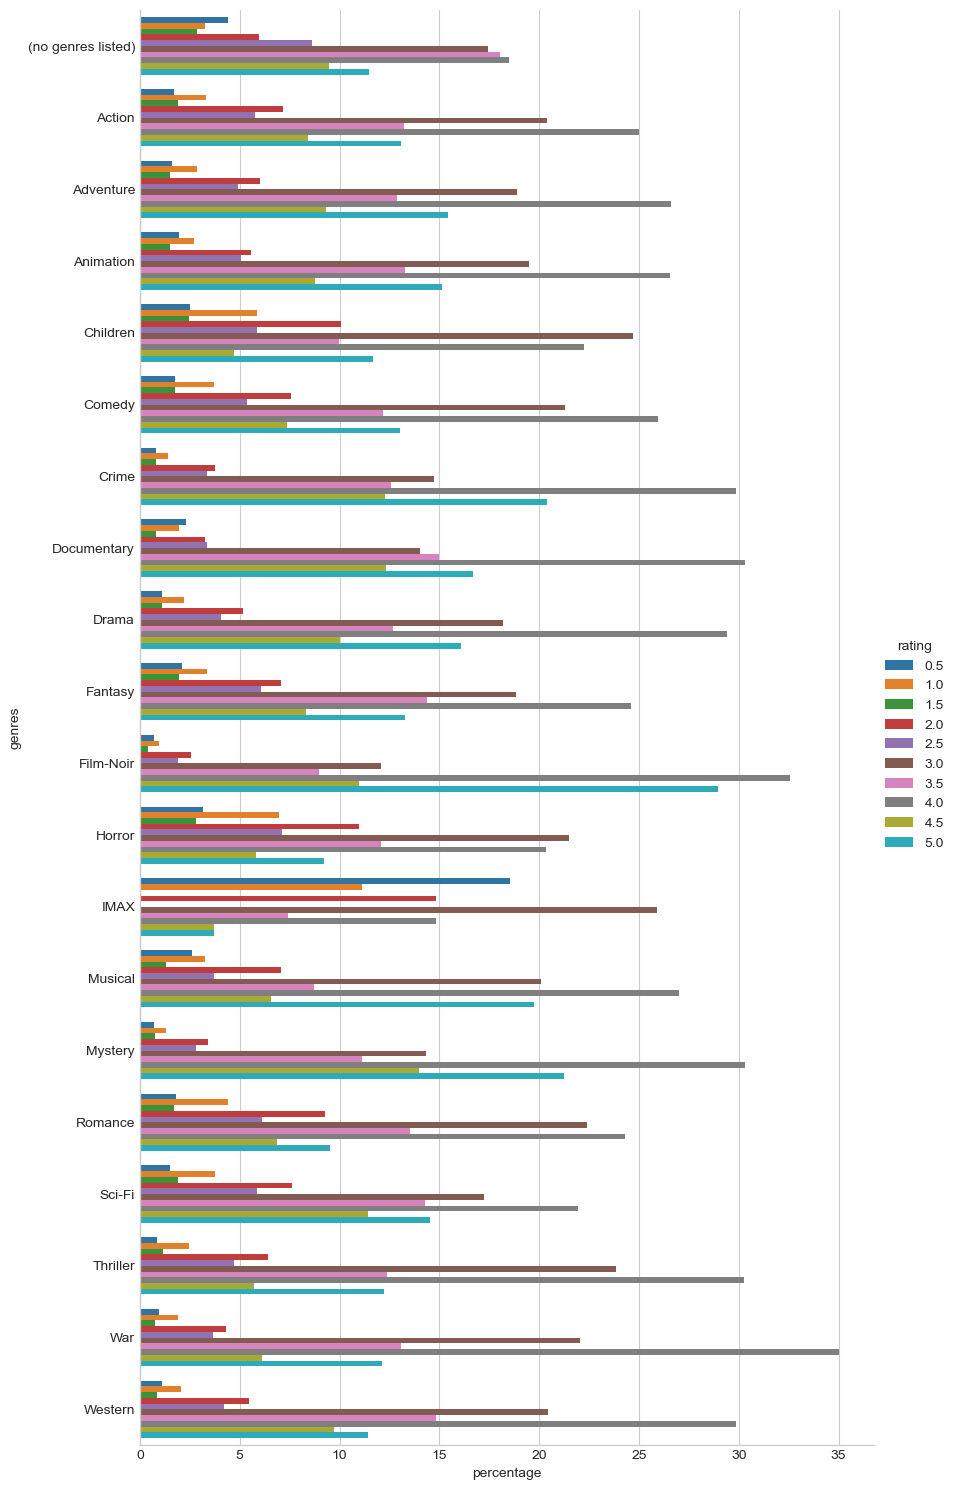

In [35]:
# Create plots with a percentage count of user ratings per genre for each rating level
rating_counts = merged_movie_ratings_df.groupby(['genres', 'rating']).userId.count().reset_index(name='count')
total_counts = merged_movie_ratings_df.groupby('genres').userId.count().reset_index(name='total_count')
percentage_counts = pd.merge(rating_counts, total_counts, on='genres')
percentage_counts['percentage'] = (percentage_counts['count'] / percentage_counts['total_count']) * 100

sns.catplot(x='percentage', y='genres',hue='rating', data=percentage_counts, kind='bar',aspect=0.6, height=15)

We can just see the ratings at each genre. It is too broad so we will only consider popular genre

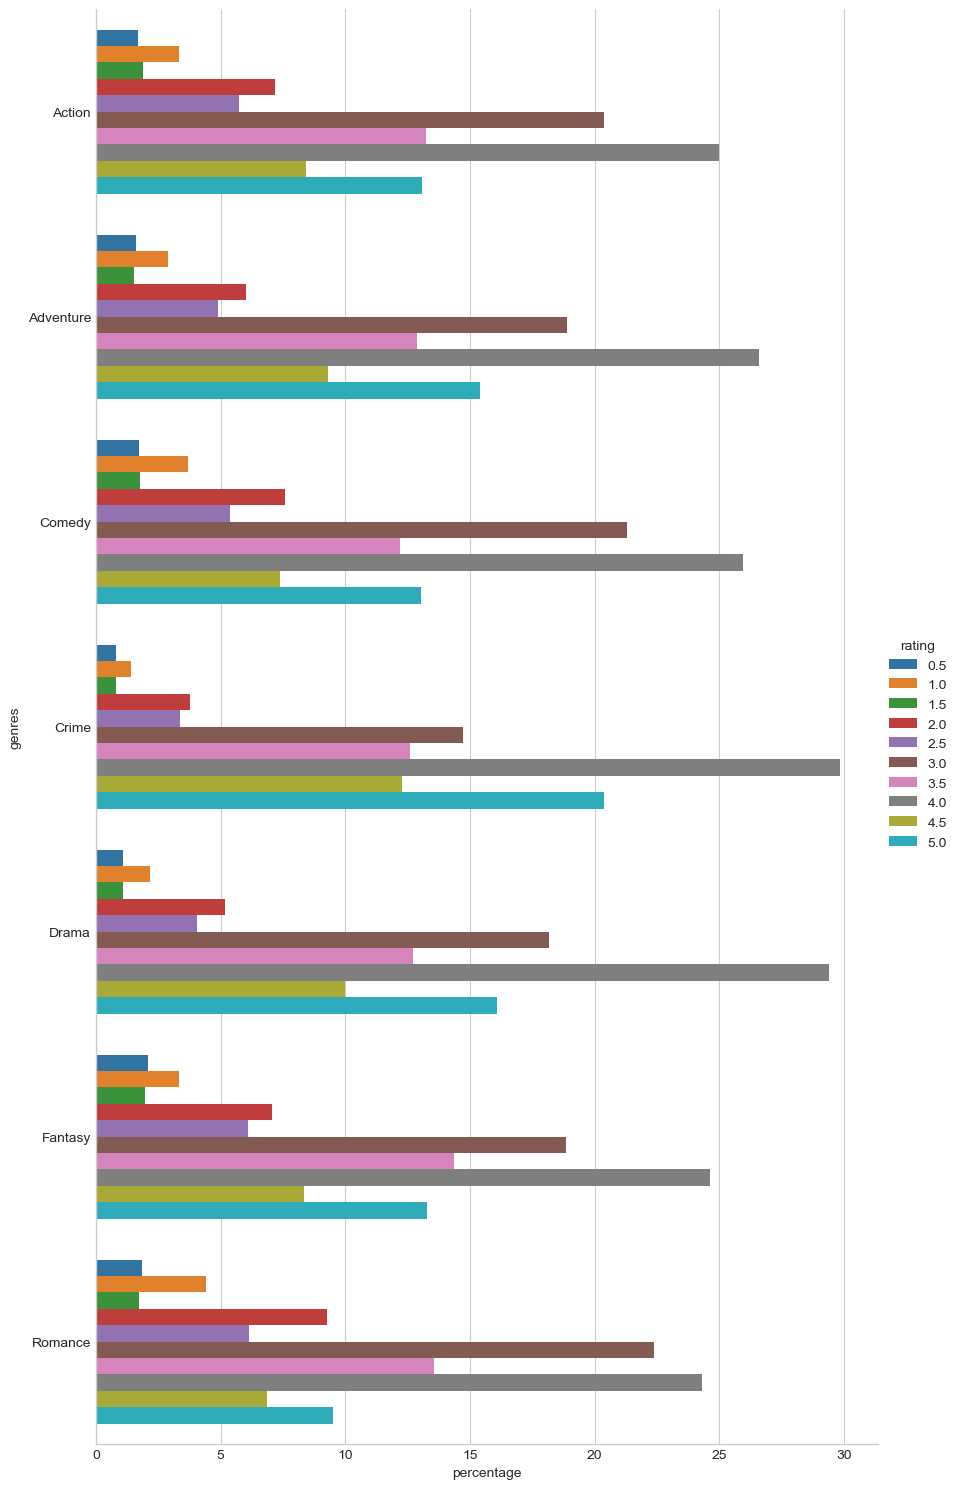

In [36]:
# Filter the DataFrame for specific genres
specific_genres = ['Action', 'Comedy', 'Drama', 'Adventure', 'Crime', 'Romance', 'Fantasy']
merged_movie_ratings_df = merged_movie_ratings_df[merged_movie_ratings_df['genres'].isin(specific_genres)]

# Create a percentage count of user ratings per genre for each rating level
rating_counts = merged_movie_ratings_df.groupby(['genres', 'rating']).userId.count().reset_index(name='count')
total_counts = merged_movie_ratings_df.groupby('genres').userId.count().reset_index(name='total_count')
percentage_counts = pd.merge(rating_counts, total_counts, on='genres')
percentage_counts['percentage'] = (percentage_counts['count'] / percentage_counts['total_count']) * 100

# Plot the percentage counts for specific genres
sns.catplot(x='percentage', y='genres', hue='rating', data=percentage_counts, kind='bar', aspect=0.6, height=15)
plt.show()

We can just see even popular genres have not high ratings, 
They might have some quality issues or bad story or something.

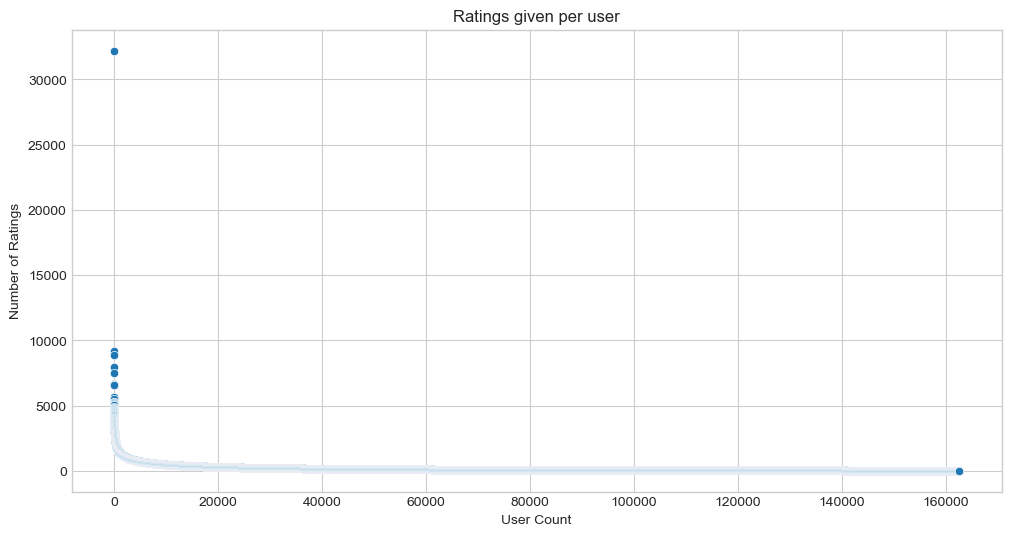

In [38]:
# Draw the plots with individual user and number of ratings
# to see the distribution of number of ratings per user
rating_users = df_ratings['userId'].value_counts().reset_index().\
               rename(columns={'index': 'userId', 'userId': 'RatingCount'})

plt.figure(figsize=(12, 6))
sns.scatterplot(x=rating_users.index, y='RatingCount', data=rating_users)
plt.title('Ratings given per user')
plt.xlabel('User Count')  
plt.ylabel('Number of Ratings')
plt.show();

There is inherent bias in the dataset. </br>
There are few users who rate a lot & several users that provide very few ratings. </br>
One user has provided 32K+ ratings</br>
So we are going to try several datasets having different number of users based on the trend above. It would be too big for analysis.</br>

In [39]:
rating_users.head(1000)

userId  RatingCount
0     72315        32202
1     80974         9178
2    137293         8913
3     33844         7919
4     20055         7488
..      ...          ...
995  120166         1443
996  128243         1442
997   93305         1442
998   91434         1441
999   83814         1440

[1000 rows x 2 columns]

In [40]:
rating_users.shape

(162541, 2)

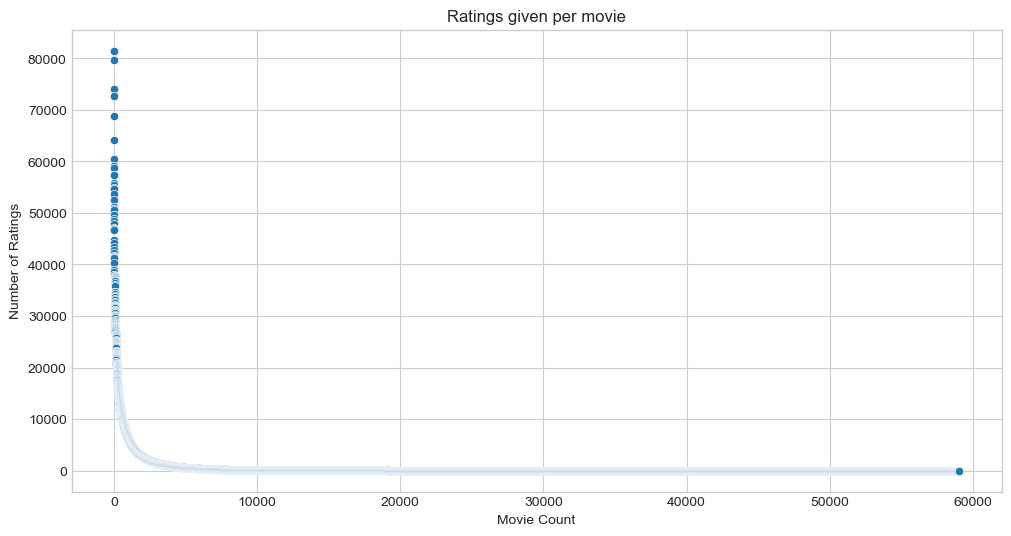

In [42]:
# Draw the same plot with individual movie and number of ratings
rating_movies = df_ratings['movieId'].value_counts().reset_index().\
               rename(columns={'index': 'movieId', 'movieId': 'RatingCount'})

plt.figure(figsize=(12, 6))
sns.scatterplot(x=rating_movies.index, y='RatingCount', data=rating_movies)
plt.title('Ratings given per movie')
plt.xlabel('Movie Count')  
plt.ylabel('Number of Ratings')
plt.show()

A similar bias is observed. </br>
There are a few movies that have received many ratings </br>
and several movies that have received very few ratings. </br>
One movie has received over 81k ratings, </br>
So we are going to try several datasets having different number of movies as well based on the trend above. It would be too big for analysis.</br>

In [44]:
rating_movies.head(2100)

movieId  RatingCount
0         356        81491
1         318        81482
2         296        79672
3         593        74127
4        2571        72674
...       ...          ...
2095    58293         2532
2096    44694         2531
2097     6187         2529
2098     2312         2527
2099    71379         2526

[2100 rows x 2 columns]

In [45]:
rating_movies.shape

(59047, 2)

We tried to execute several dataset with different the number of users & moives 
at the later part
But the user who have more than 1,400 ratings per use and 2,500 ratings per movie shows
the best performance. So We are going to user this dataset for our model

In [46]:
user_filter = rating_users[rating_users['RatingCount'] > 1400]['userId']
movie_filter = rating_movies[rating_movies['RatingCount'] > 2500]['movieId']

df_ratings2 = df_ratings[df_ratings['userId'].isin(user_filter) & df_ratings['movieId'].isin(movie_filter)]

In [47]:
df_ratings2.shape

(1128299, 4)

In [48]:
df_ratings2.head()

userId  movieId  rating   timestamp
68417     548        1     4.5  1431644949
68418     548        2     4.0  1431645039
68419     548        6     4.0  1431645064
68420     548        9     3.0  1431644952
68421     548       10     3.5  1431644914

In [49]:
# We are not considering timestamp data for our current project.
df_ratings3 = df_ratings2.drop(columns=['timestamp'])
df_ratings3.head()

userId  movieId  rating
68417     548        1     4.5
68418     548        2     4.0
68419     548        6     4.0
68420     548        9     3.0
68421     548       10     3.5

In [50]:
# Check the number of unique user
df_ratings3['userId'].nunique()

1102

In [51]:
# Check the number of unique movie
df_ratings3['movieId'].nunique()

2112

In [52]:
df_movies = pd.read_csv('movies.csv')

In [53]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [55]:
# Check for duplicate values
print(f'Duplicate entries: {df_ratings3.duplicated().sum()}')

Duplicate entries: 0


In [56]:
df_ratings3

userId  movieId  rating
68417        548        1     4.5
68418        548        2     4.0
68419        548        6     4.0
68420        548        9     3.0
68421        548       10     3.5
...          ...      ...     ...
24996291  162516   177593     4.0
24996294  162516   177765     3.5
24996298  162516   179819     3.5
24996312  162516   187593     3.5
24996320  162516   195159     3.5

[1128299 rows x 3 columns]

In [57]:
# Check the null values
df_ratings3.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [61]:
df_ratings3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128299 entries, 68417 to 24996320
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1128299 non-null  int64  
 1   movieId  1128299 non-null  int64  
 2   rating   1128299 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 34.4 MB


In [62]:
# float64 -> flost32 because float64 type takes lots of memory resources 
# to create similarity matrix 
df_ratings3['rating'] = df_ratings3['rating'].astype('float32')

In [63]:
# Take into consideration for the future analysis (Conver movieId to title)
df_ratings4 = df_ratings3.merge(df_movies, on="movieId")[['userId','title','rating']] 
df_ratings4.head()

userId             title  rating
0     548  Toy Story (1995)     4.5
1     626  Toy Story (1995)     4.5
2     847  Toy Story (1995)     4.0
3     997  Toy Story (1995)     4.5
4    1401  Toy Story (1995)     4.5

In [66]:
# Check the number of values per userId
counts = df_ratings3['userId'].value_counts()
print(counts)

107650    2107
57548     2099
72315     2006
20055     1921
162516    1867
          ... 
108821     400
10623      341
14501      315
75309      302
73268      238
Name: userId, Length: 1102, dtype: int64


### 3. Modeling (Collaborative filtering & Content-based filtering)

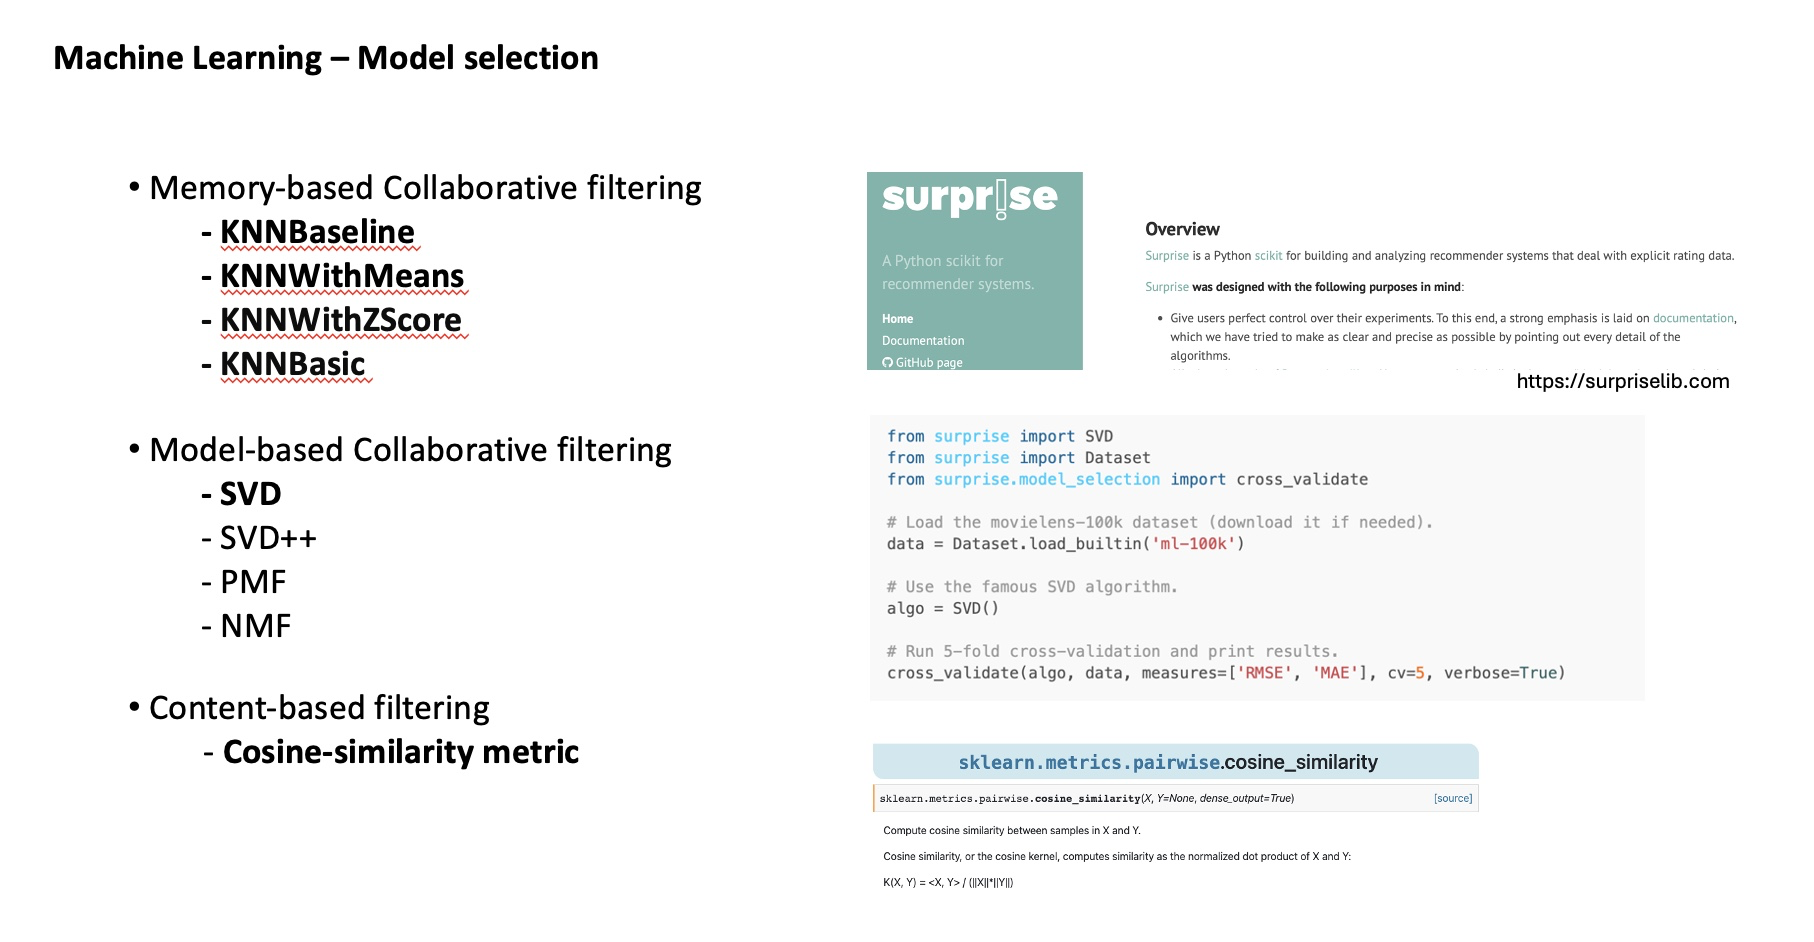

In [3]:
from IPython.display import Image, display
display(Image(filename='models.png', width=600, height=600))

### 3.1 Collaborative filtering : KNN & SVD algorithm

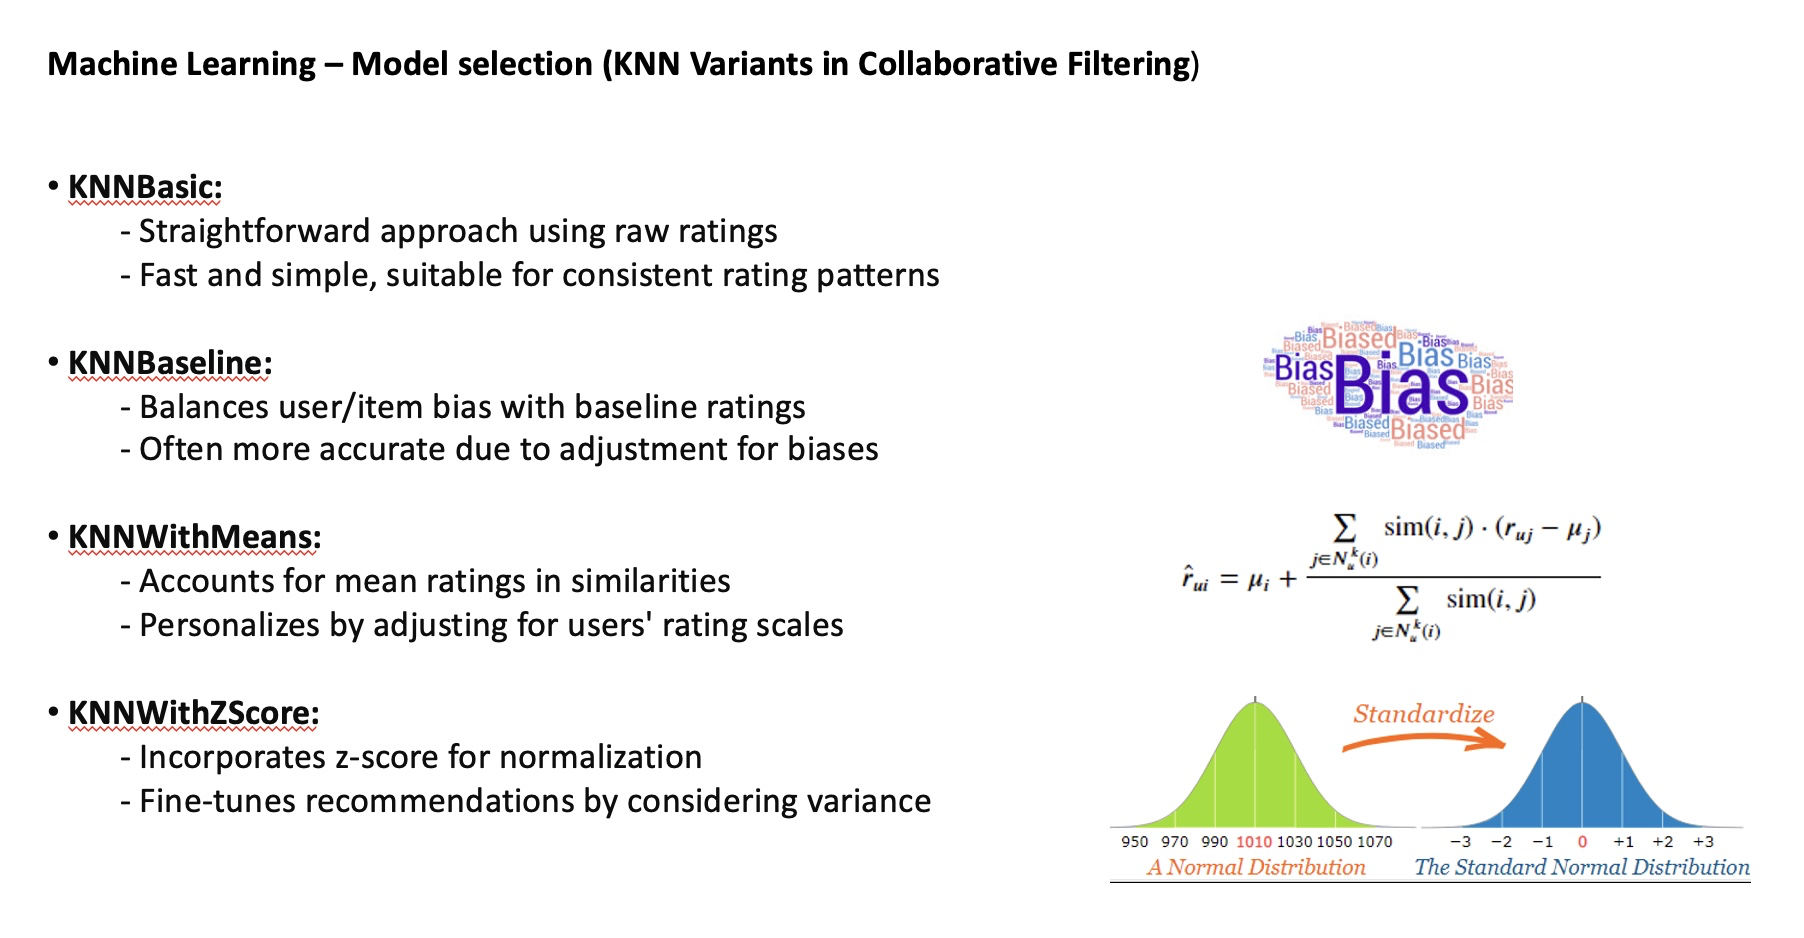

In [4]:
from IPython.display import Image, display
display(Image(filename='KNNs.png', width=600, height=600))

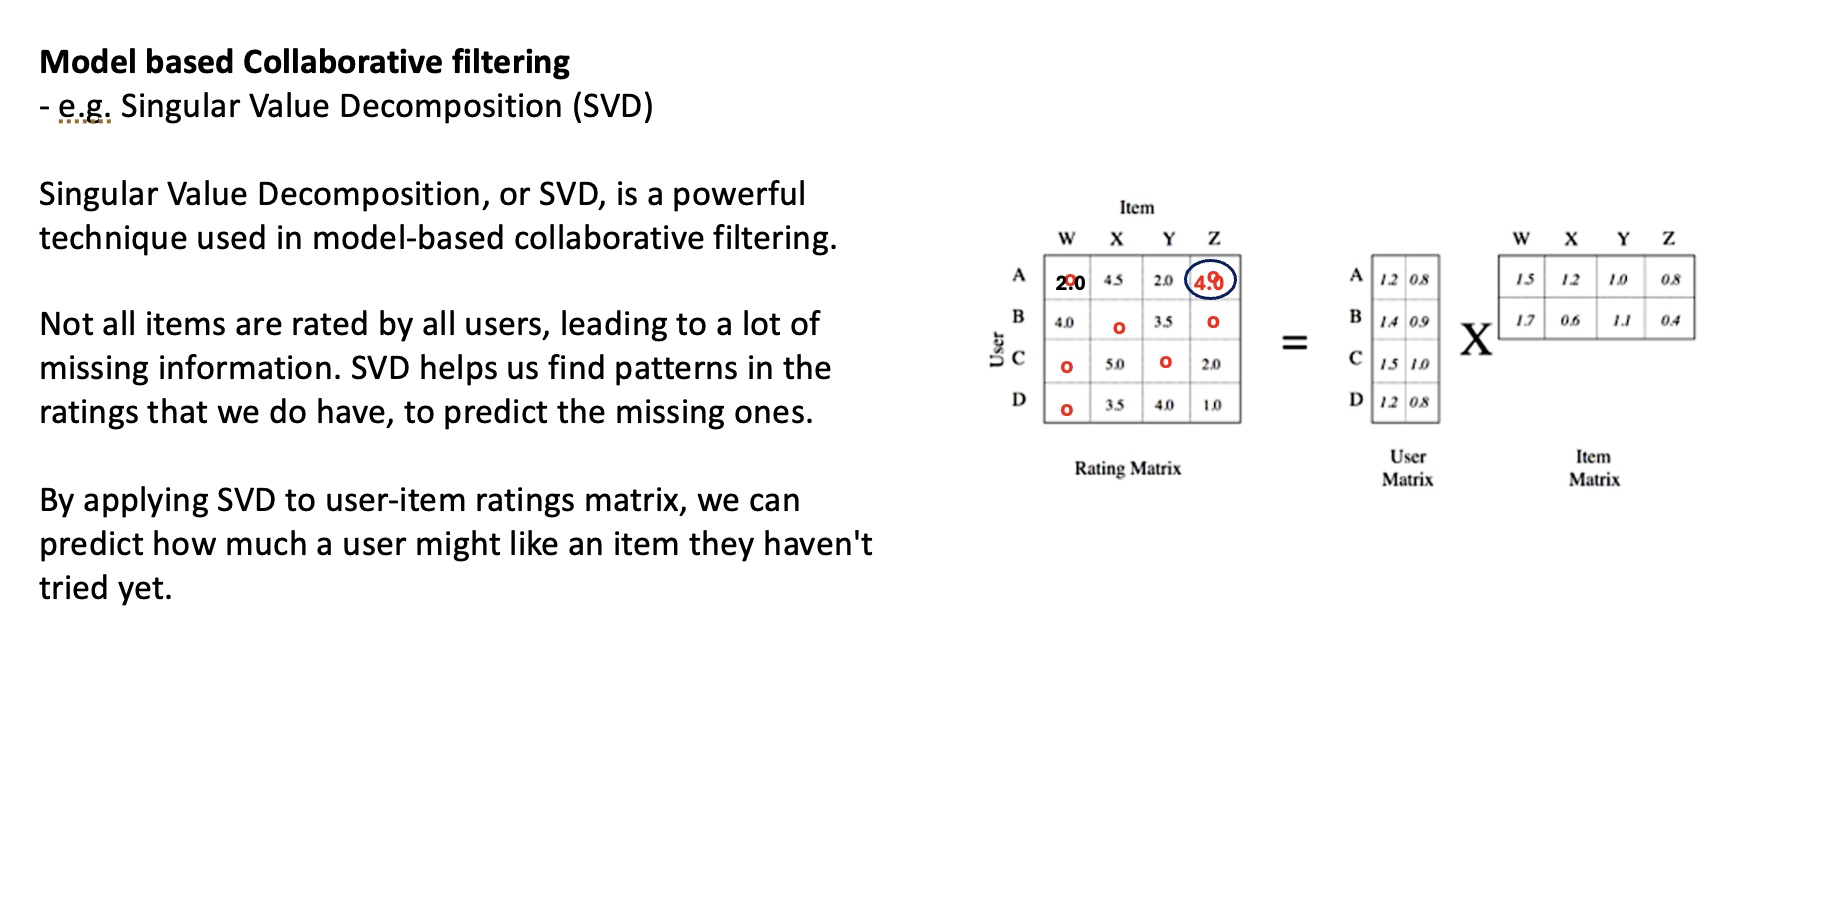

In [10]:
from IPython.display import Image, display
display(Image(filename='svd.png', width=600, height=600))

In [83]:
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise import accuracy
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio

In [84]:
df_ratings

userId  movieId  rating   timestamp
0              1      296     5.0  1147880044
1              1      306     3.5  1147868817
2              1      307     5.0  1147868828
3              1      665     5.0  1147878820
4              1      899     3.5  1147868510
...          ...      ...     ...         ...
25000090  162541    50872     4.5  1240953372
25000091  162541    55768     2.5  1240951998
25000092  162541    56176     2.0  1240950697
25000093  162541    58559     4.0  1240953434
25000094  162541    63876     5.0  1240952515

[25000095 rows x 4 columns]

1. First approach would be creating model with random samples without considering the distribution

In [85]:
def safe_sample(group, n):
    if len(group) >= n:
        return group.sample(n)
    return group.head(0)  # return an empty dataframe for groups with less than n entries

# Random sample users
sampled_users2 = df_ratings.groupby('userId').apply(safe_sample, n=1000).reset_index(drop=True)

In [86]:
sampled_users2 = sampled_users2.drop(columns=['timestamp'])

In [87]:
sampled_users2

userId  movieId  rating
0           187      786     3.5
1           187     6377     4.0
2           187     1682     5.0
3           187    71379     4.0
4           187     2279     3.0
...         ...      ...     ...
2674995  162516     7986     1.5
2674996  162516     7581     2.0
2674997  162516    26585     1.5
2674998  162516     2507     1.0
2674999  162516    87192     3.5

[2675000 rows x 3 columns]

In [88]:
sampled_users2['userId'].nunique()

2675

In [89]:
sampled_users2['movieId'].nunique()

42378

In [90]:
# Creating dataset for KNN recommendation model based on standard format
import random

reader2 = Reader(rating_scale=(0,10))
data2 = Dataset.load_from_df(sampled_users2[['userId', 'movieId', 'rating']], reader2)

raw_ratings2 = data2.raw_ratings
random.shuffle(raw_ratings2)

threshold2 = int(len(raw_ratings2)*0.8)

train_raw_ratings2 = raw_ratings2[:threshold2]
test_raw_ratings2 = raw_ratings2[threshold2:]

data2.raw_ratings = train_raw_ratings2
trainset2 = data2.build_full_trainset()
testset2 = data2.construct_testset(test_raw_ratings2)

In [91]:
# check loaded dataset
data2

In [92]:
# check train set
trainset2

In [93]:
# check test set
testset2

[(10106, 648, 3.0),
 (150585, 157, 1.0),
 (107414, 1022, 4.0),
 (94219, 25771, 3.5),
 (127746, 1526, 2.0),
 (81403, 176, 3.5),
 (121477, 8765, 3.5),
 (35651, 69278, 3.5),
 (61869, 3022, 2.5),
 (11747, 3550, 0.5),
 (79203, 338, 3.0),
 (111798, 78499, 2.5),
 (94548, 90249, 2.5),
 (18426, 58559, 4.0),
 (92257, 78893, 3.0),
 (150150, 4720, 3.5),
 (6118, 2379, 3.0),
 (106706, 6281, 4.0),
 (147116, 7252, 2.0),
 (147993, 3267, 4.0),
 (124905, 2193, 3.5),
 (87116, 3844, 3.5),
 (114682, 933, 4.0),
 (158243, 6595, 3.5),
 (86844, 586, 2.5),
 (37945, 4018, 3.0),
 (156183, 89753, 2.0),
 (116230, 1909, 4.0),
 (42148, 85131, 2.0),
 (59034, 2320, 3.0),
 (147174, 93831, 3.5),
 (132085, 30707, 2.5),
 (139874, 101761, 3.0),
 (109168, 1597, 2.5),
 (143000, 4963, 3.5),
 (39916, 3421, 3.5),
 (7248, 3871, 3.0),
 (17664, 162350, 3.0),
 (49004, 2142, 1.5),
 (66948, 58627, 4.0),
 (69687, 98604, 1.5),
 (3624, 2351, 4.5),
 (82994, 149352, 3.5),
 (116319, 6987, 0.5),
 (140815, 8459, 5.0),
 (38446, 500, 2.0),
 (466

In [94]:
# Creating KNN models as well as SVD with Crossvalidation (MAE and RMSE)
models2 = [KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD()]
results2 = {}

for model in models2:
    CV_scores = cross_validate(model, data2, measures=['MAE', 'RMSE'], cv=5, n_jobs=-1)
    
    result2 = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
            rename({'test_name': 'MAE', 'test_rmse': 'RMSE'})
    
    results2[str(model).split('algorithms.')[1].split('object')[0]] = result2

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done co

In [95]:
# Check the performance of models (KNNs, SVD)
performance_df2 = pd.DataFrame.from_dict(results2)
print("Model Performance: \n")
performance_df2.T.sort_values(by='RMSE')

Model Performance: 



test_mae      RMSE  fit_time  test_time
matrix_factorization.SVD   0.582689  0.769060  7.566493   1.378544
knns.KNNBaseline           0.611480  0.803819  8.810723  40.993050
knns.KNNWithMeans          0.623559  0.816340  8.529295  39.210579
knns.KNNWithZScore         0.618118  0.819220  9.054559  43.497224
knns.KNNBasic              0.640275  0.845787  8.395272  37.597119

The best performing model based on RMSE is SVD with a value of 0.769060,</br>
and it also has the shortest fit_time of 7.566493 and test_time of 1.378544.</br>

2. Next approach would be creating model with specified samples </br>(Users have ratings more than 1,400ea and movies have ratings more than 2,500ea)

In [96]:
reader = Reader(rating_scale=(0,10))
data = Dataset.load_from_df(df_ratings4[['userId', 'title', 'rating']], reader)

raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)

threshold = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = train_raw_ratings
trainset = data.build_full_trainset()
testset = data.construct_testset(test_raw_ratings)


In [97]:
#Check data
data 

In [98]:
#Check trainset
trainset

In [99]:
#Check testset
testset

[(5742, 'Omen, The (1976)', 2.5),
 (132358, 'Willow (1988)', 3.0),
 (128876, 'Lilo & Stitch (2002)', 3.5),
 (98227, 'Driving Miss Daisy (1989)', 4.0),
 (127746, "Mr. Holland's Opus (1995)", 4.0),
 (155778, 'Crash (1996)', 3.0),
 (85034, 'Transporter 2 (2005)', 3.5),
 (7403, 'Mimic (1997)', 3.5),
 (74644, 'Back to the Future (1985)', 4.0),
 (134386, 'Turner & Hooch (1989)', 3.5),
 (69289, 'Bourne Ultimatum, The (2007)', 4.0),
 (100171, 'Terminator 2: Judgment Day (1991)', 5.0),
 (50651, 'Long Kiss Goodnight, The (1996)', 3.5),
 (2177, 'Othello (1995)', 3.0),
 (6497, 'While You Were Sleeping (1995)', 1.5),
 (10496, 'Indiana Jones and the Kingdom of the Crystal Skull (2008)', 3.5),
 (24692, 'Rainmaker, The (1997)', 3.0),
 (8979, 'Mulholland Drive (2001)', 4.0),
 (25857, "Man Who Wasn't There, The (2001)", 4.5),
 (97896, 'Star Wars: Episode V - The Empire Strikes Back (1980)', 5.0),
 (7784, 'True Lies (1994)', 3.0),
 (84293, 'Cape Fear (1962)', 4.0),
 (160858, 'Lolita (1962)', 4.0),
 (1088

In [100]:
# Run KNN models and SVD with same Crossvalidation (MAE, RMSE)
models = [KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD()]
results = {}

for model in models:
    CV_scores = cross_validate(model, data, measures=['MAE', 'RMSE'], cv=5, n_jobs=-1)
    
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
            rename({'test_name': 'MAE', 'test_rmse': 'RMSE'})
    
    results[str(model).split('algorithms.')[1].split('object')[0]] = result

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done co

In [72]:
# Check the performance of models
performance_df = pd.DataFrame.from_dict(results)
print("Model Performance: \n")
performance_df.T.sort_values(by='RMSE')

Model Performance: 



test_mae      RMSE  fit_time  test_time
matrix_factorization.SVD   0.555202  0.735065  2.738692   0.464876
knns.KNNBaseline           0.596420  0.784245  2.127610  16.939502
knns.KNNWithMeans          0.602326  0.789270  2.086609  15.593563
knns.KNNWithZScore         0.599377  0.795918  2.095154  16.388760
knns.KNNBasic              0.614752  0.811507  2.016142  15.457511

Recent dataset demonstrates improved performance across all models.</br> 
Specifically, the SVD model now achieves an RMSE of 0.735065, with reduced fit_time (2.738692) and test_time (0.464876)</br>
Moreover SVD has reduced from 7.566493 to 2.738692, and its test_time has decreased from 1.378544 to 0.464876.</br>
Similarly, KNN models also exhibit reduced fit_time and test_time metrics in the recent dataset compared to the previous one.</br>
So we can say we successfuly reduced the size of dataset with better performance.

#### GridSearchCV for KNNBaseline

In [101]:
from surprise.model_selection import GridSearchCV

# We tried several combination of hyperparmeters but this combination shows best performance
# So only remaining this code for interpretability.

param_grid = {
    'k': [10, 20, 40],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson_baseline'],
        'user_based': [True, False]
    },
    'bsl_options': {
        'method': ['als', 'sgd'],
        'n_epochs': [5, 10]
    }
}

# Use the GridSearchCV class from the surprise library
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)

# Show best RMSE score
print("best RMSE score", gs.best_score['rmse'])
print("Best hyperparameters for RMSE", gs.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity ma

Best hyperparameters for RMSE {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'bsl_options': {'method': 'als', 'n_epochs': 10}}

#### Model fit & prediction - KNNBaseline

In [102]:
# Executing with best combination of hyperparameter from GridSearch above
param_options = {'name':'pearson_baseline', 
                 'user_based':False, 'k':20, 'method':'als', 'n_epochs':5}
final_model = KNNBaseline(sim_options=param_options)

pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance:')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Unbiased Testing Performance:
MAE:  0.5462
RMSE: 0.7240
MAE: 0.5462072319000799, RMSE: 0.7239969119644525


Unbiased Testing Performance:</br>
MAE:  0.5462</br>
RMSE: 0.7240</br>
MAE: 0.5462072319000799, RMSE: 0.7239969119644525</br>

The MAE & RMSE metrics for testset are comparable with what was obtained using cross validation & hyperparameter tuning stages with trainset. Chosen model hence, generalizes well

#### GridSearchCV for SVD model

In [109]:
# We also tried several combination of hyperparmeters but this combination shows best performance
# So only remaining this code for interpretability.

# param_grid = {"n_factors": range(10,100,20),
#               "n_epochs" : [5, 10, 20],
#               "lr_all"   : [0.002, 0.005],
#               "reg_all"  : [0.2, 0.5]}

# param_grid = {
#     'n_factors': [50, 100, 200],    
#     'n_epochs': [20, 30, 50],       
#     'lr_all': [0.003, 0.007, 0.01], 
#     'reg_all': [0.02, 0.05, 0.1] 
# }

param_grid = {
    'n_factors': [20, 50, 70],       
    'n_epochs': [10, 20, 30],       
    'lr_all': [0.005, 0.01, 0.05],   
    'reg_all': [0.01, 0.02, 0.04] 
}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)
                                    
gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

MAE Best Parameters:  {'n_factors': 70, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.04}
MAE Best Score:       0.5493338938215773

RMSE Best Parameters: {'n_factors': 70, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.04}
RMSE Best Score:      0.7261316279411061



RMSE Best Parameters: {'n_factors': 70, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.04}</br>
RMSE Best Score:      0.7261316279411061

In [110]:
# final_model = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all= 0.2)
# final_model = SVD(n_factors=200, n_epochs=50, lr_all=0.007, reg_all= 0.5)
final_model = SVD(n_factors=70, n_epochs=30, lr_all=0.01, reg_all= 0.04)


pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')


Unbiased Testing Performance
MAE:  0.5438
RMSE: 0.7187
MAE: 0.5437994571368753, RMSE: 0.7186743404772782


Unbiased Testing Performance</br>
MAE:  0.5438</br>
RMSE: 0.7187</br>
MAE: 0.5437994571368753, RMSE: 0.7186743404772782</br>

It also shows similar RMSE score with testset as trainset, so the model is generalized well. 

### 4. Predictions & Findings - Collaborative filtering (KNNs, SVD)

In [75]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_ratings3[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

- 1. Generating recommendation with KNNBaseline

In [100]:
def generate_recommendationsKNN(userID=548, like_recommend=5, get_recommend =10):
    
    # Compute item based similarity matrix
    param_options = {'name':'pearson_baseline', 
                 'user_based':False, 'k':20, 'method':'als', 'n_epochs':5}
    similarity_matrix = KNNBaseline(sim_options=param_options).fit(trainset).\
                        compute_similarities() 
    
    userID      = trainset.to_inner_uid(userID)    # converts the raw userID to innerID
    userRatings = trainset.ur[userID]              # method .ur takes user innerID & 
                                                   # returns back user ratings
    
    
    temp_df = pd.DataFrame(userRatings).sort_values(by=1, ascending=False).\
              head(like_recommend)
    userRatings = temp_df.to_records(index=False) 
    
    # for each (movie,rating) in top like_recommend user movies, multiply the user rating for
    # the movie with the similarity score (later is obtained from movie similarity_matrix) for
    # all movies. This helps calculate the weighted rating for all movies. The weighted ratings 
    # are added & divided by sum of weights to estimate rating the user would give a movie
    
    recommendations   = {}

    for user_top_item, user_top_item_rating  in userRatings:

        all_item_indices          =   list(pd.DataFrame(similarity_matrix)[user_top_item].index)
        all_item_weighted_rating  =   list(pd.DataFrame(similarity_matrix)[user_top_item].values*\
                                          user_top_item_rating)
        
        all_item_weights          =   list(pd.DataFrame(similarity_matrix)[user_top_item].values)
        
        
        # All movies & final estimated ratings are added to a dictionary called recommendations
        
        for index in range(len(all_item_indices)):
            if index in recommendations:
                # sum of weighted ratings
                recommendations[index] += all_item_weighted_rating[index]        
            else:                        
                recommendations[index]  = all_item_weighted_rating[index]

    
    for index in range(len(all_item_indices)):                               
            if all_item_weights[index]  !=0:
                # final ratings (sum of weighted ratings/sum of weights)
                recommendations[index]   =recommendations[index]/\
                                          (all_item_weights[index]*like_recommend)
                      

    # convert dictionary recommendations to a be a list of tuples
    # with each tuple being an movie & estimated rating user would give that movie
    # sort the tuples within the list to be in decreasing order of estimated ratings

    temp_df = pd.Series(recommendations).reset_index().sort_values(by=0, ascending=False)
    recommendations = list(temp_df.to_records(index=False))
    
    # return get_recommend number of recommedations (only return movies the user 
    # has not previously rated)
    
    final_recommendations = []
    count = 0
    
    for item, score in recommendations:
        flag = True
        for userItem, userRating in trainset.ur[userID]:
            if item == userItem: 
                flag = False       # If item in recommendations has not been rated by user, 
                break              # add to final_recommendations
        if flag == True:
            final_recommendations.append(trainset.to_raw_iid(item)) 
            count +=1              # trainset has the items stored as inner id,  
                                   # convert to raw id & append 
            
        if count > get_recommend:  # Only get 'get_recommend' number of recommendations
            break
    
    return(final_recommendations)

In [102]:
# We are trying to get recommendations for userId=548
recommendationsKNN = generate_recommendationsKNN(userID=548, like_recommend=5, get_recommend=10)
recommendationsKNN

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[3062, 2533, 98491, 2412, 6385, 605, 88, 1371, 30707, 2804, 1408]

In [120]:
filtered_df = df_ratings3[df_ratings3['userId'] == 548][['movieId']]
filtered_df

movieId
68417        1
68418        2
68419        6
68420        9
68421       10
...        ...
71253   119141
71254   119145
71288   122882
71290   122892
71392   134368

[1120 rows x 1 columns]

In [108]:
## Show the movie title and movieId
movie_lists = [3062, 2533, 98491, 2412, 6385, 605, 88, 1371, 30707, 2804, 1408]
movie_titles = df_movies[df_movies['movieId'].isin(movie_lists)]
movie_titles

movieId                                      title  \
87          88                         Black Sheep (1996)   
597        605                        One Fine Day (1996)   
1335      1371       Star Trek: The Motion Picture (1979)   
1370      1408           Last of the Mohicans, The (1992)   
2321      2412                             Rocky V (1990)   
2442      2533  Escape from the Planet of the Apes (1971)   
2712      2804                  Christmas Story, A (1983)   
2969      3062                    Longest Day, The (1962)   
6266      6385                         Whale Rider (2002)   
9423     30707                 Million Dollar Baby (2004)   
18896    98491                            Paperman (2012)   

                           genres  
87                         Comedy  
597                 Drama|Romance  
1335             Adventure|Sci-Fi  
1370   Action|Romance|War|Western  
2321                 Action|Drama  
2442                Action|Sci-Fi  
2712              Children|Comedy  
2969             Action|Drama|War  
6266                        Drama  
9423                        Drama  
18896    Animation|Comedy|Romance

In [5]:
watched_movies = df_ratings3[df_ratings3['userId'] == 548]
watched_genres = df_movies[df_movies['movieId'].isin(watched_movies['movieId'])]['genres']


recommended_movies = movie_titles  
recommended_genres = recommended_movies['genres']

def count_genre_occurrences(genres_series):
    genre_counts = {}
    for genres in genres_series:
        for genre in genres.split('|'):
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1
    return genre_counts


watched_genre_counts = count_genre_occurrences(watched_genres)
recommended_genre_counts = count_genre_occurrences(recommended_genres)

watched_genre_df = pd.DataFrame(list(watched_genre_counts.items()), columns=['Genre', 'Count'])
recommended_genre_df = pd.DataFrame(list(recommended_genre_counts.items()), columns=['Genre', 'Count'])

watched_colors = "skyblue"
recommended_colors = "lightgreen"

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

watched_genre_df.sort_values('Count', ascending=False).plot(kind='bar', x='Genre', y='Count', ax=axes[0], title='Watched Movies Genre Distribution', color=watched_colors)
recommended_genre_df.sort_values('Count', ascending=False).plot(kind='bar', x='Genre', y='Count', ax=axes[1], title='Recommended Movies Genre Distribution', color=recommended_colors)

plt.tight_layout()
plt.show()

NameError: name 'df_ratings3' is not defined

- 2. Generating recommendation with SVD

In [88]:
# SVD
def generate_recommendationsSVD(userID=548, get_recommend =10):
    

    model = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all= 0.2)
    model.fit(trainset)
    
    # predict rating for all pairs of users & items that are not in the trainset
    
    testset = trainset.build_anti_testset()
    predictions = model.test(testset)
    predictions_df = pd.DataFrame(predictions)
    
    # get the top get_recommend predictions for userID
    
    predictions_userID = predictions_df[predictions_df['uid'] == userID].\
                         sort_values(by="est", ascending = False).head(get_recommend)
    
    recommendations = []
    recommendations.append(list(predictions_userID['iid']))
    recommendations = recommendations[0]
    
    return(recommendations)

IndentationError: unexpected indent (4249018955.py, line 20)

In [87]:
recommendationsSVD = generate_recommendationsSVD(userID=548, get_recommend =10)
recommendationsSVD

[858, 1221, 912, 1193, 922, 2019, 904, 908, 750, 1203]

In [27]:
# Show the movies and titles
movie_lists2 = [858, 1221, 912, 1193, 922, 2019, 904, 908, 750, 1203]
movie_titles2 = df_movies[df_movies['movieId'].isin(movie_lists2)]
movie_titles2

movieId                                              title  \
734       750  Dr. Strangelove or: How I Learned to Stop Worr...   
840       858                              Godfather, The (1972)   
883       904                                 Rear Window (1954)   
887       908                          North by Northwest (1959)   
891       912                                  Casablanca (1942)   
901       922      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
1164     1193             One Flew Over the Cuckoo's Nest (1975)   
1173     1203                                12 Angry Men (1957)   
1190     1221                     Godfather: Part II, The (1974)   
1930     2019        Seven Samurai (Shichinin no samurai) (1954)   

                                         genres  
734                                  Comedy|War  
840                                 Crime|Drama  
883                            Mystery|Thriller  
887   Action|Adventure|Mystery|Romance|Thriller  
891                               Drama|Romance  
901                     Drama|Film-Noir|Romance  
1164                                      Drama  
1173                                      Drama  
1190                                Crime|Drama  
1930                     Action|Adventure|Drama

### 3. Modeling (Content-based Filtering)

In [26]:
merged_movie_meta_df.isnull().sum()

movieId                 0
title                   0
genres_y                0
budget                  0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
vote_average            0
vote_count              0
dtype: int64

In [27]:
merged_movie_meta_df['status_binary'] = merged_movie_meta_df['status'].apply(lambda x: 1 if x == 'Released' else 0)


In [28]:
import pandas as pd

# Split the 'genres_y' column on commas into a list of genres
merged_movie_meta_df['genres_y'] = merged_movie_meta_df['genres_y'].str.split(', ')

# handle both the splitting and the one-hot encoding
genres_dummies = merged_movie_meta_df['genres_y'].apply(lambda x: pd.Series(1, index=x)).fillna(0, downcast='infer')

merged_movie_meta_df = merged_movie_meta_df.join(genres_dummies)



In [65]:
# Convert 'release_date' to a numerical value: days since the most recent release in the dataset
merged_movie_meta_df['release_date'] = pd.to_datetime(merged_movie_meta_df['release_date'])
most_recent_date = merged_movie_meta_df['release_date'].max()
merged_movie_meta_df['days_since_release'] = (most_recent_date - merged_movie_meta_df['release_date']).dt.days
merged_movie_meta_df.head(2)

movieId      title                      genres_y      budget  popularity  \
0        1  Toy Story   [Animation, Comedy, Family]  30000000.0   21.946943   
1        2    Jumanji  [Adventure, Fantasy, Family]  65000000.0   17.015539   

      production_companies      production_countries release_date  \
0  Pixar Animation Studios  United States of America   1995-10-30   
1         TriStar Pictures  United States of America   1995-12-15   

       revenue  runtime  ...    Science Fiction  War  Foreign  TV Movie  \
0  373554033.0     81.0  ...  0               0    0        0         0   
1  262797249.0    104.0  ...  0               0    0        0         0   

   Music  Documentary  Western  Mystery  days_since_release  
0      0            0        0        0                8463  
1      0            0        0        0                8417  

[2 rows x 37 columns]

In [66]:
vote_average = merged_movie_meta_df['vote_average']
vote_average

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
69956    6.9
69972    5.9
69975    5.5
69993    6.3
70028    7.3
Name: vote_average, Length: 41422, dtype: float64

In [67]:
columns_to_drop = ['title', 'genres_y', 'production_companies', 'production_countries', 'spoken_languages', 'status', 'release_date','vote_average','vote_count','popularity']
contentbased_df = merged_movie_meta_df.drop(columns=columns_to_drop)

In [68]:
contentbased_df.columns 

Index(['movieId', 'budget', 'revenue', 'runtime', 'status_binary', 'Animation',
       'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'History', '',
       'Science Fiction', 'War', 'Foreign', 'TV Movie', 'Music', 'Documentary',
       'Western', 'Mystery', 'days_since_release'],
      dtype='object')

In [69]:
contentbased_df

movieId      budget      revenue  runtime  status_binary  Animation  \
0            1  30000000.0  373554033.0     81.0              1          1   
1            2  65000000.0  262797249.0    104.0              1          0   
2            3   9500000.0   17405415.0    101.0              1          0   
3            4  16000000.0   81452156.0    127.0              1          0   
4            5   9500000.0   76578911.0    106.0              1          0   
...        ...         ...          ...      ...            ...        ...   
69956   208800   9500000.0   93600000.0     76.0              1          1   
69972   208861  70000000.0   76066841.0     96.0              1          0   
69975   208887   9500000.0   17405415.0     82.0              1          0   
69993   208945   9500000.0   17405415.0    111.0              1          0   
70028   209143   9500000.0      11229.0     76.0              1          1   

       Comedy  Family  Adventure  Fantasy  ...     Science Fiction  War  \
0           1       1          0        0  ...  0                0    0   
1           0       1          1        1  ...  0                0    0   
2           1       0          0        0  ...  0                0    0   
3           1       0          0        0  ...  0                0    0   
4           1       0          0        0  ...  0                0    0   
...       ...     ...        ...      ...  ... ..              ...  ...   
69956       0       1          0        0  ...  0                0    0   
69972       0       0          0        0  ...  0                1    0   
69975       1       0          0        0  ...  0                0    0   
69993       0       0          0        1  ...  0                1    0   
70028       0       0          0        1  ...  0                0    0   

       Foreign  TV Movie  Music  Documentary  Western  Mystery  \
0            0         0      0            0        0        0   
1            0         0      0            0        0        0   
2            0         0      0            0        0        0   
3            0         0      0            0        0        0   
4            0         0      0            0        0        0   
...        ...       ...    ...          ...      ...      ...   
69956        0         0      0            0        0        0   
69972        0         0      0            0        0        0   
69975        0         0      0            0        0        0   
69993        0         0      0            0        0        0   
70028        0         0      0            0        0        0   

       days_since_release  
0                    8463  
1                    8417  
2                    8410  
3                    8410  
4                    8725  
...                   ...  
69956               23209  
69972                4269  
69975                6674  
69993                8466  
70028                2596  

[41422 rows x 27 columns]

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Normalize the data
scaler = StandardScaler()
contentbased_df_scaled = scaler.fit_transform(contentbased_df.drop(columns=['movieId']))

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(contentbased_df_scaled)

In [71]:
contentbased_df_scaled

array([[ 1.03915536,  5.03352248, -0.47401992, ..., -0.15088218,
        -0.24849275, -0.13436405],
       [ 3.08911195,  3.42391485,  0.18299469, ..., -0.15088218,
        -0.24849275, -0.13943122],
       [-0.16153349, -0.1423188 ,  0.09729714, ..., -0.15088218,
        -0.24849275, -0.14020231],
       ...,
       [-0.16153349, -0.1423188 , -0.44545407, ..., -0.15088218,
        -0.24849275, -0.33143292],
       [-0.16153349, -0.1423188 ,  0.38295566, ..., -0.15088218,
        -0.24849275, -0.13403358],
       [-0.16153349, -0.39510525, -0.61684919, ..., -0.15088218,
        -0.24849275, -0.7806486 ]])

In [72]:
# Function to find similar movies by name
def find_similar_movies_by_name(movie_name, df, cosine_sim_matrix, top_n=5):
    movie_id = df[df['title'].str.contains(movie_name, case=False, na=False)]['movieId'].iloc[0]
    
    movie_index = df.index[df['movieId'] == movie_id].tolist()[0]
    
    movie_sim_scores = list(enumerate(cosine_sim_matrix[movie_index]))
    
    movie_sim_scores = sorted(movie_sim_scores, key=lambda x: x[1], reverse=True)
    
    top_movie_indices = [index for index, sim_score in movie_sim_scores[1:top_n+1]]
    
    similar_movies = [(df.iloc[idx]['title'], sim_score) for idx, sim_score in movie_sim_scores[1:top_n+1]]
    
    return similar_movies

### 4. Predictions & Findings - Content-based filtering

In [73]:
movie_name = "Toy Story"  # movie name you want to find similar movies for
similar_movies = find_similar_movies_by_name(movie_name, merged_movie_meta_df, cosine_sim_matrix, top_n=5)

print(f"Movies similar to '{movie_name}':")
movies = []
similarity_scores = []
for movie, score in similar_movies:
    print(f"{movie}: {score:.3f}")
    movies.append(movie)
    similarity_scores.append(score)

Movies similar to 'Toy Story':
Chicken Run: 0.963
Hotel Transylvania 2: 0.951
Over the Hedge: 0.943
Toy Story 2: 0.938
Despicable Me: 0.928


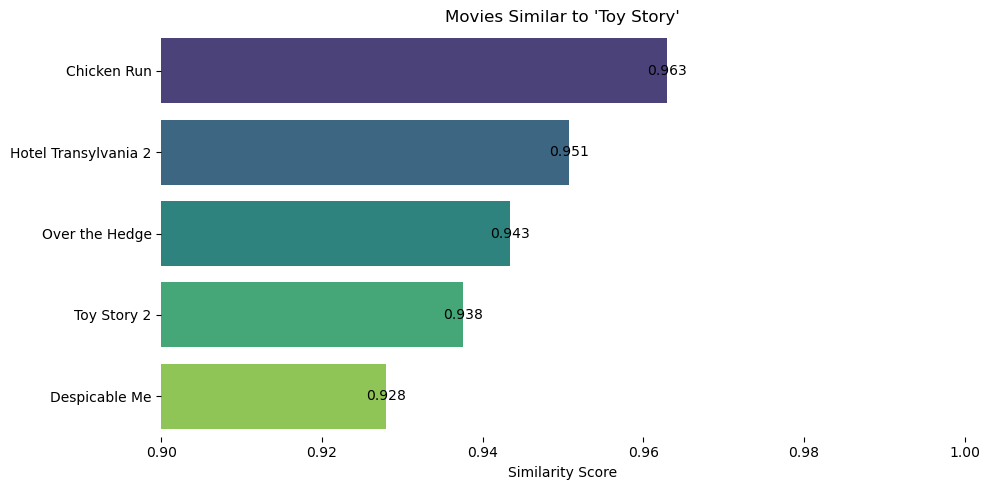

In [74]:
plt.figure(figsize=(10, 5))
sns.barplot(x=similarity_scores, y=movies, palette='viridis')

for index, value in enumerate(similarity_scores):
    plt.text(value, index, f'{value:.3f}', color='black', ha='center', va='center')

plt.xlabel('Similarity Score')
plt.title("Movies Similar to 'Toy Story'")
plt.xlim(0.9, 1.0)  

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


- Compared to ToyStory, the lists of movies show similar genre like Toy story2

In [75]:
movie_name = "Jumanji"  
similar_movies = find_similar_movies_by_name(movie_name, merged_movie_meta_df, cosine_sim_matrix, top_n=5)
similar_movies

print(f"Movies similar to '{movie_name}':")
movies_jumanji = []
similarity_scores_jumanji = []
for movie, score in similar_movies:
    print(f"{movie}: {score:.3f}")
    movies_jumanji.append(movie)
    similarity_scores_jumanji.append(score)

Movies similar to 'Jumanji':
Percy Jackson & the Olympians: The Lightning Thief: 0.976
Pete's Dragon: 0.972
Pete's Dragon: 0.972
Percy Jackson: Sea of Monsters: 0.969
Hook: 0.955


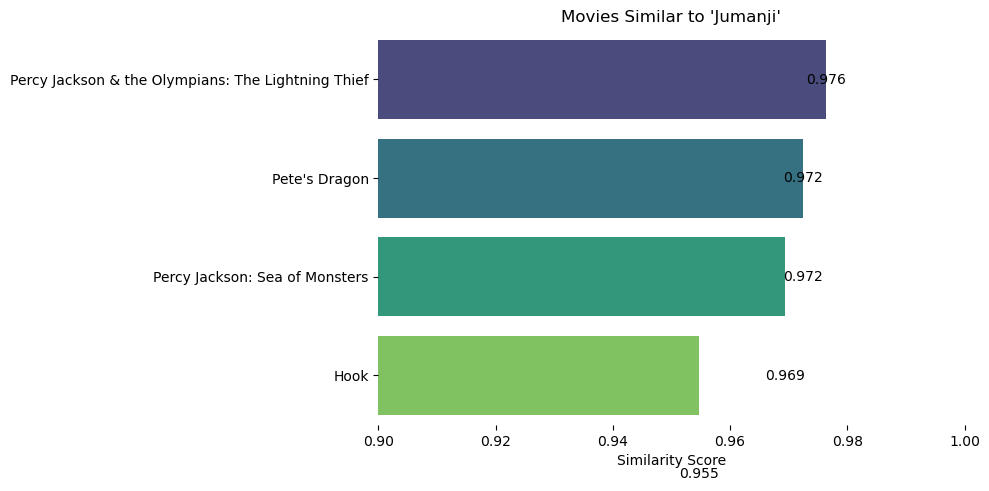

In [76]:
plt.figure(figsize=(10, 5))
sns.barplot(x=similarity_scores_jumanji, y=movies_jumanji, palette='viridis')

for index, value in enumerate(similarity_scores_jumanji):
    plt.text(value, index, f'{value:.3f}', color='black', ha='center', va='center')

plt.xlabel('Similarity Score')
plt.title("Movies Similar to 'Jumanji'")
plt.xlim(0.9, 1.0)  

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


- Compared to Jumanji, the lists of movies show similar genre

### 4. Conclusion

- We succesfully optimized the size of dataset and selected effective metrics with GridSearchCV for KNN models and SVD in terms of Collaborative filtering approach.</br>
--> Utilize new concepts such as Baysian optimization would be better for efficiency and performance. </br>

- We are not considering timestamp data feature for our project. So it may overlook evolving trends in user preferences.</br>
--> Analyze individual user session data can be particularly useful for sequential recommendation.

- Our dataset might have biased values even we cleaned and reduced. KNNbaseline with Pearson Baseline similarity excelled in handling ratings biases well.</br>
--> In terms of performance, it would be better using deep learning algoritms instead to capture intricate and complex paterns of user preference.

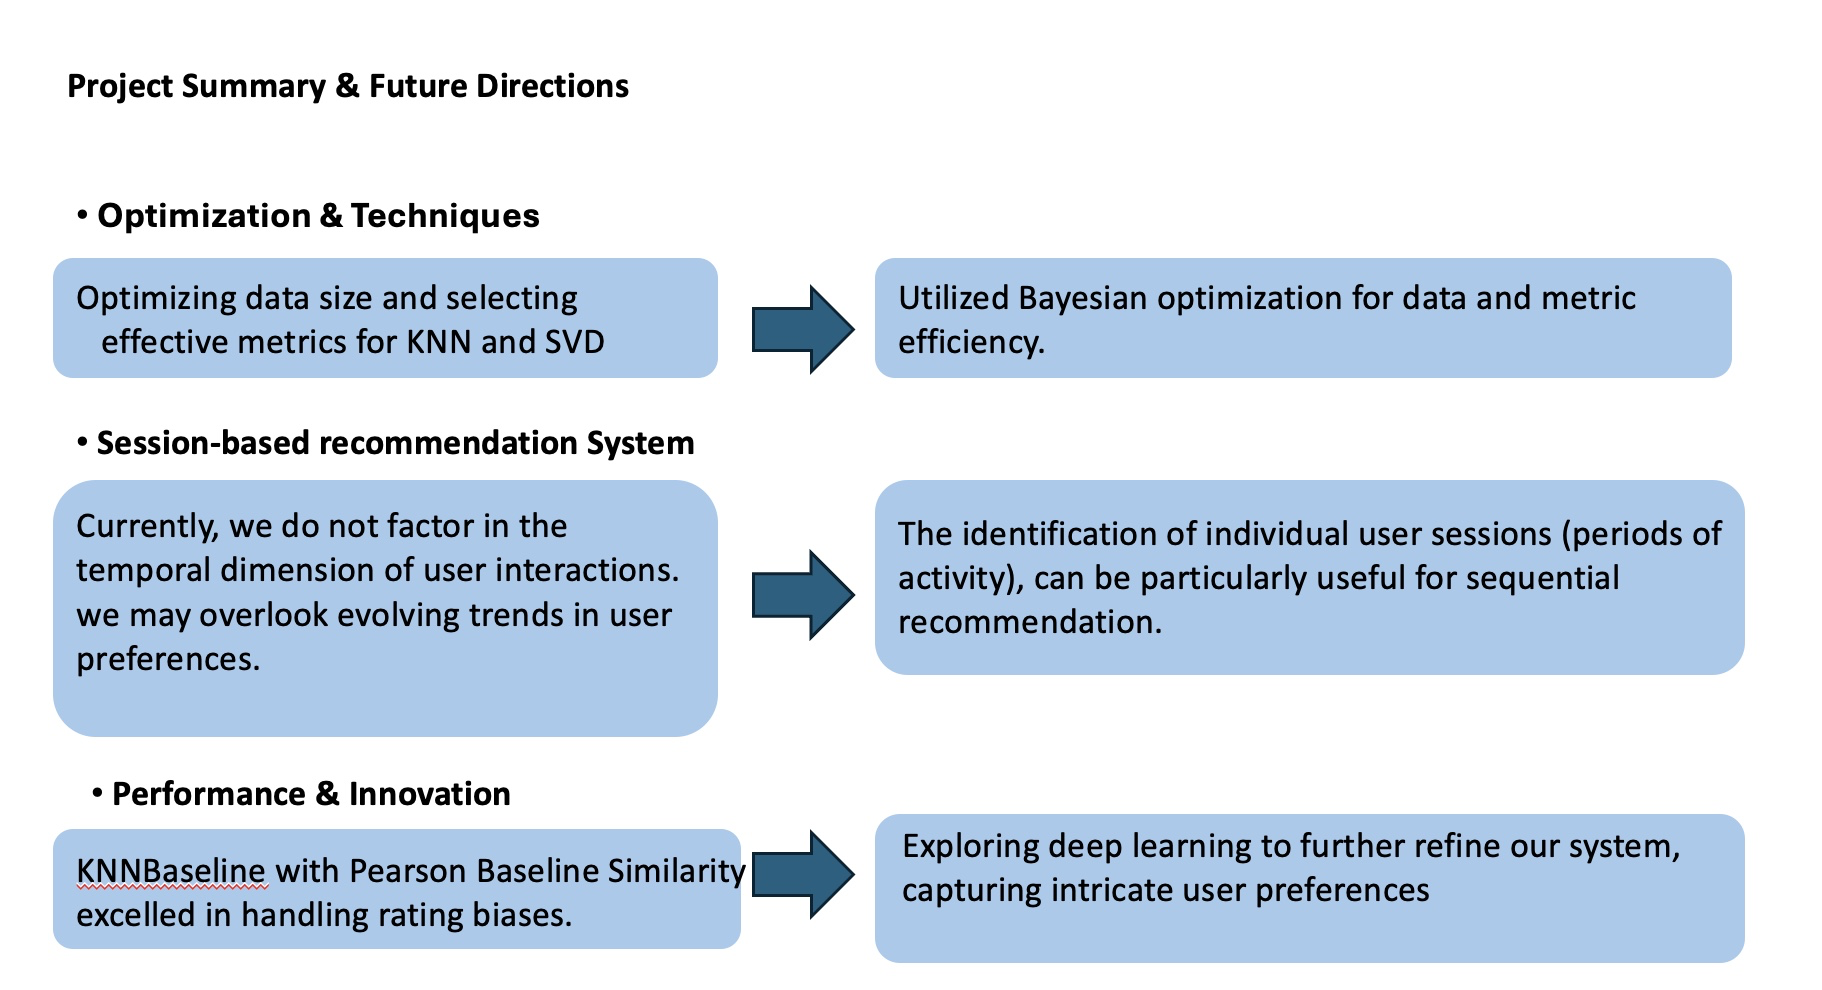

In [8]:
from IPython.display import Image, display
display(Image(filename='summary.png', width=800, height=800))